# Neural Networks and Deep Learning

## Homework 2 - Unsupervised Learning

### Academic Year 2021/2022 
### Dr. Alberto Testolin, Dr. Umberto Michieli

### Capettini Croatto Hilario

In [1]:
##IMPORTS
#Basics
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # create directories in the local filesystem
from tqdm import tqdm # plot progress bars
import plotly.express as px

#PyTorch
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import  DataLoader
from torch import nn
import torch.optim as optim
import torch.nn.functional as F

#For Optuna (Hyperparameters search)
import optuna
from optuna.integration import PyTorchLightningPruningCallback

#Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

# For latent space exploration
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Models definitions and training models
import model as my_models


In [2]:
# Set seeds for reproducibility (PyTorch, Python, Numpy)
matricola = 2013031
torch.manual_seed(matricola)
random.seed(matricola)
np.random.seed(matricola)


# Import the data

In [3]:
### Download the data and create dataset
data_dir = "C:/Users/hilar/Documents/Data/GitHub/NNDL/Homework_2_Unsupervised_Learning/dataset"


# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=False)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=False)


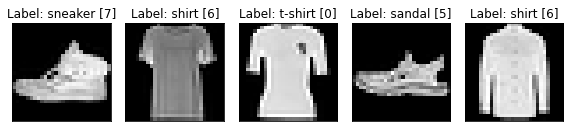

In [4]:
### Plot some sample
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(1, 5, figsize=(8,8))
for ax in axs.flatten():
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('./Img/clothe_samples.svg', format='svg')
plt.tight_layout()

In [5]:
### Define transforms
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                     ])
test_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                     ])

### Set the train and test transform
train_dataset.transform = train_transform
test_dataset.transform = test_transform

### Define train/test iterator
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)


In [6]:
batch_data, batch_labels = next(iter(train_dataloader))
print(f"TRAIN BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

batch_data, batch_labels = next(iter(test_dataloader))
print(f"TEST BATCH SHAPE")
print(f"\t Data: {batch_data.shape}")
print(f"\t Labels: {batch_labels.shape}")

TRAIN BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])
TEST BATCH SHAPE
	 Data: torch.Size([256, 1, 28, 28])
	 Labels: torch.Size([256])


# Implement autoencoder

**2 pt - Implement and test (convolutional) autoencoder, reporting the trend of reconstruction loss and some examples of image reconstruction; explore advanced optimizers and regularization methods**


In [7]:
encoded_space_dim = 2     # Dimension of the encoding space
max_epochs        = 10  
learning_rate     = 1e-3
regularization    = 0.
nf                = 8    # Number of filters

In [8]:
# Initialize the autoencoder
AE = my_models.Autoencoder(encoded_space_dim,nf)


In [9]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE.to(device)


Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(inplac

  0%|          | 0/10 [00:00<?, ?it/s]

EPOCH 1/10
AVERAGE TRAIN LOSS: 0.09352520853281021
AVERAGE TEST LOSS: 0.04420451447367668


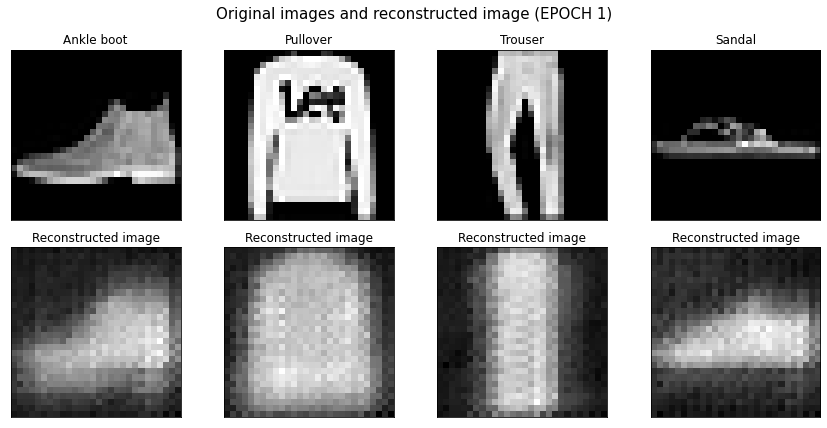

 10%|█         | 1/10 [00:16<02:25, 16.21s/it]

EPOCH 2/10
AVERAGE TRAIN LOSS: 0.04079596325755119


 20%|██        | 2/10 [00:31<02:07, 15.94s/it]

AVERAGE TEST LOSS: 0.03858013451099396
EPOCH 3/10
AVERAGE TRAIN LOSS: 0.036981791257858276


 30%|███       | 3/10 [00:47<01:51, 15.86s/it]

AVERAGE TEST LOSS: 0.03614874556660652
EPOCH 4/10
AVERAGE TRAIN LOSS: 0.03516588360071182


 40%|████      | 4/10 [01:03<01:34, 15.79s/it]

AVERAGE TEST LOSS: 0.03479894623160362
EPOCH 5/10
AVERAGE TRAIN LOSS: 0.034024063497781754


 50%|█████     | 5/10 [01:19<01:18, 15.76s/it]

AVERAGE TEST LOSS: 0.03388182446360588
EPOCH 6/10
AVERAGE TRAIN LOSS: 0.03324159234762192
AVERAGE TEST LOSS: 0.03303322196006775


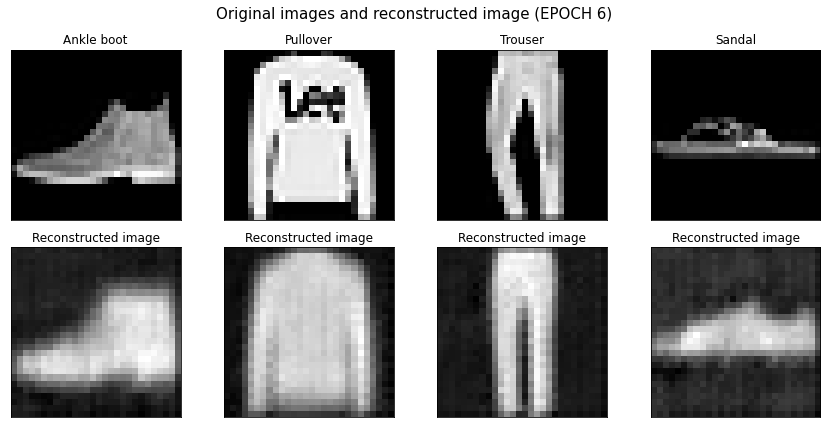

 60%|██████    | 6/10 [01:35<01:03, 15.83s/it]

EPOCH 7/10
AVERAGE TRAIN LOSS: 0.03249266371130943


 70%|███████   | 7/10 [01:50<00:47, 15.81s/it]

AVERAGE TEST LOSS: 0.03245032578706741
EPOCH 8/10
AVERAGE TRAIN LOSS: 0.0318208672106266


 80%|████████  | 8/10 [02:06<00:31, 15.73s/it]

AVERAGE TEST LOSS: 0.031884707510471344
EPOCH 9/10
AVERAGE TRAIN LOSS: 0.031369615346193314


 90%|█████████ | 9/10 [02:21<00:15, 15.66s/it]

AVERAGE TEST LOSS: 0.03140050917863846
EPOCH 10/10
AVERAGE TRAIN LOSS: 0.030989881604909897


100%|██████████| 10/10 [02:37<00:00, 15.73s/it]

AVERAGE TEST LOSS: 0.030947575345635414


In [10]:
train_loss, validation_loss = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,         # I use the test subdataset for validation purpose
                                loss_fn,
                                optim,
                                max_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot = True,
                                keep_plots = False,
                                keep_model=False,
                                verbose=True)

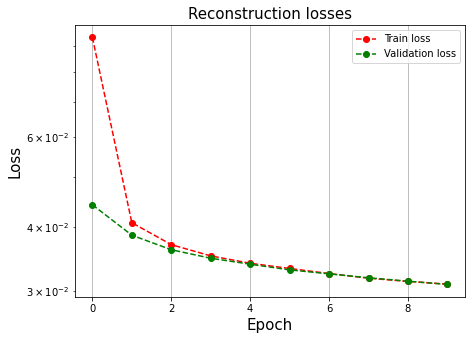

In [11]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(validation_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Reconstruction losses",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Img/example_losses.svg', format='svg')
plt.show()

# Optimize autoencoder parameters

**1 pt - optimize hyperparameters using grid/random search or automatic tuning tools (e.g., Optuna)**

In [12]:
### Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cpu


In [13]:
def objective(trial):
    max_epochs = 8
    
    # Parameters for the search
    nf                     = trial.suggest_categorical("nf", [4,8,16])
    encoded_space_dim      = trial.suggest_categorical("encoded_space_dim", [2,5,10])
    optimizer_name         = trial.suggest_categorical('optimizer_name',["SGD", "Adam"])
    lr                     = trial.suggest_loguniform("lr", 1e-5, 1e-1)
    regularization         = trial.suggest_loguniform("regularization", 1e-5, 1e-1)
    
    
    ### Initialize both network
    AE = my_models.Autoencoder(encoded_space_dim,nf)
    AE.to(device)
 
    ### Define the loss function
    loss_fn = nn.MSELoss()
    
    #Define the optimizer
    optimizer = getattr(torch.optim,optimizer_name)(AE.parameters(), lr=lr, weight_decay=regularization)
    
    #The bad thing of this simple approach is that we only consider the last epoch test loss as the valid one.
    train, test = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot       = False,
                                keep_plots = False,
                                keep_model =False,
                                verbose    =False)
 
    return test[-1]

In [14]:
#Define the study
study = optuna.create_study(study_name="no_pruning", direction="minimize")
study.optimize(objective, n_trials=200, timeout=25000) #6 hours

[I 2022-09-09 18:22:48,683] A new study created in memory with name: no_pruning
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
100%|██████████| 8/8 [01:38<00:00, 12.25s/it]
[I 2022-09-09 18:24:26,734] Trial 0 finished with value: 0.23008772730827332 and parameters: {'nf': 4, 'encoded_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 2.076761455410729e-05, 'regularization': 0.0008931352826676697}. Best is trial 0 with value: 0.23008772730827332.
100%

In [15]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 116
Best trial:
  Value: 0.01491088978946209
  Params: 
    nf: 16
    encoded_space_dim: 10
    optimizer_name: Adam
    lr: 0.004114545957907223
    regularization: 1.011471759196494e-05


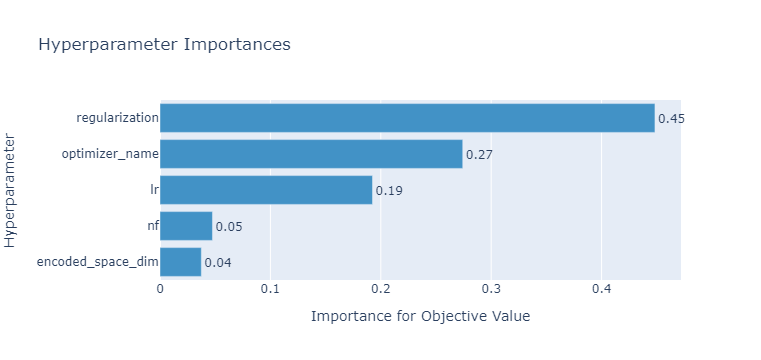

In [16]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()
fig.write_image("Img/cae_barplot.svg")

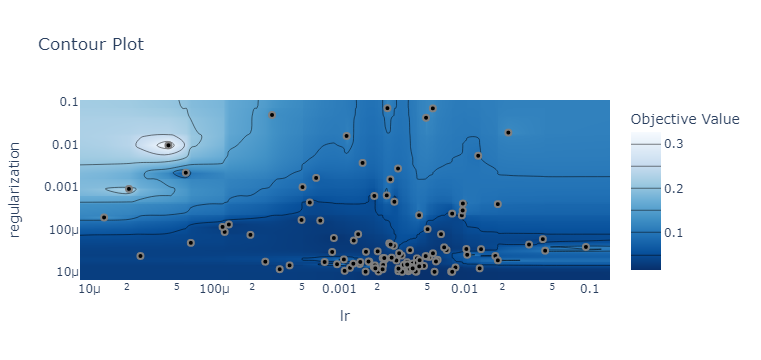

In [17]:
fig = optuna.visualization.plot_contour(study, params=['lr','regularization'])
fig.show()
fig.write_image("Img/cae_map.svg")

## Re train best model 

In [18]:
learning_rate       = trial.params['lr']
encoded_space_dim   = trial.params["encoded_space_dim"]
regularization_term = trial.params["regularization"]
nf                  = trial.params["nf"]
n_epochs = 50

In [13]:
AE = my_models.Autoencoder(encoded_space_dim,nf)

In [14]:
### Define the loss function
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE.encoder.parameters()},
    {'params': AE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization_term)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE.to(device)

Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=576, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(64, 3, 3))
    (5): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(i

  0%|          | 0/50 [00:00<?, ?it/s]

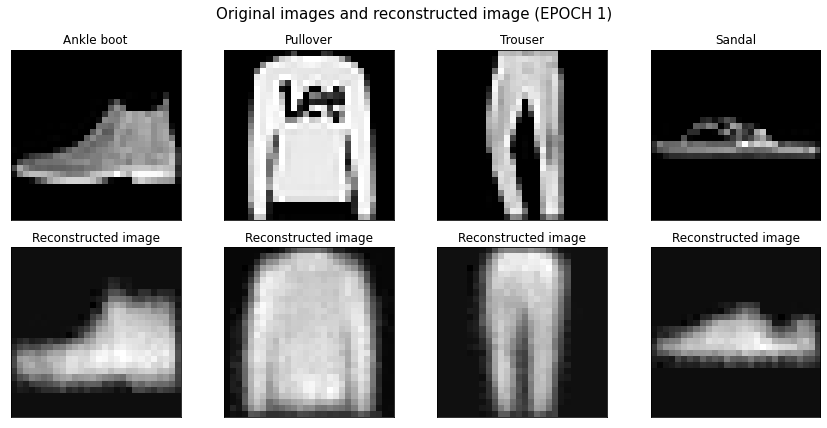

 10%|█         | 5/50 [01:57<17:31, 23.37s/it]

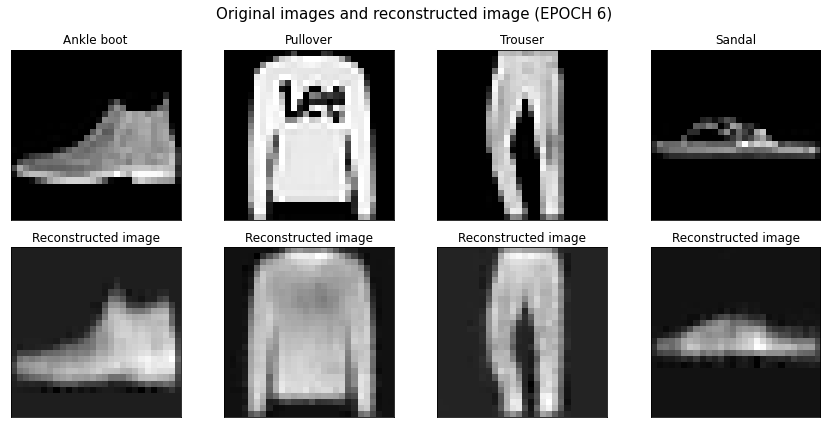

 20%|██        | 10/50 [06:29<37:38, 56.46s/it]

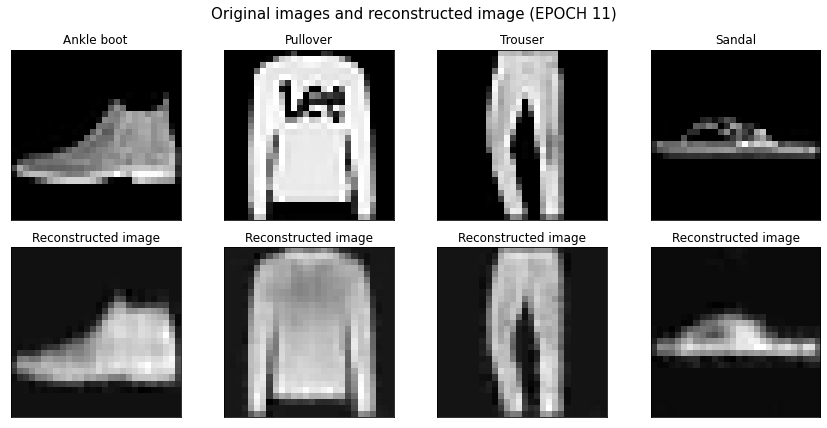

 30%|███       | 15/50 [12:55<43:28, 74.53s/it]

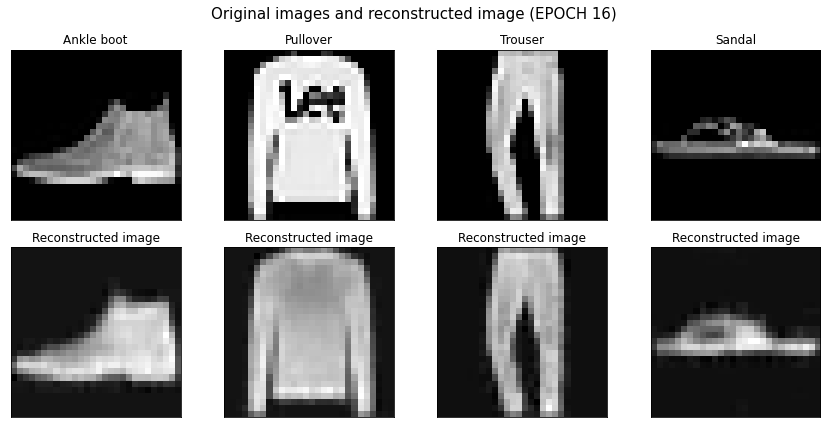

 40%|████      | 20/50 [19:26<38:49, 77.66s/it]

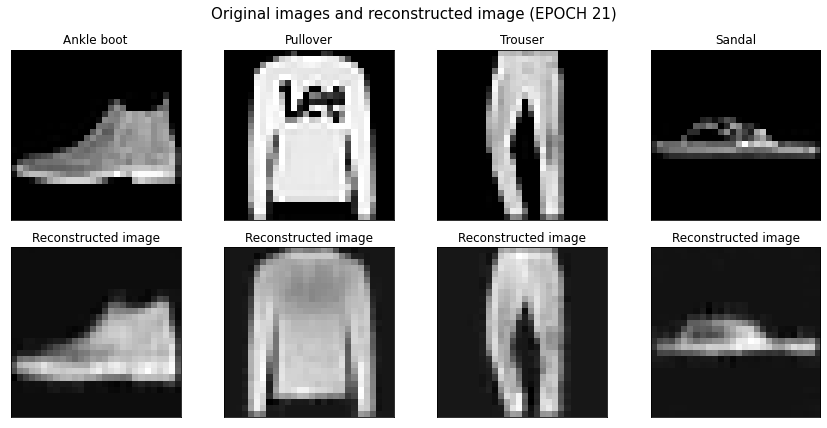

 50%|█████     | 25/50 [25:51<32:12, 77.30s/it]

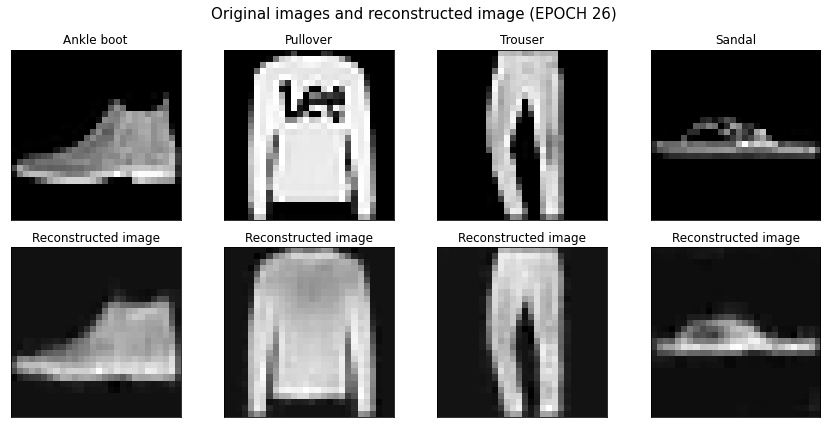

 60%|██████    | 30/50 [32:40<26:57, 80.86s/it]

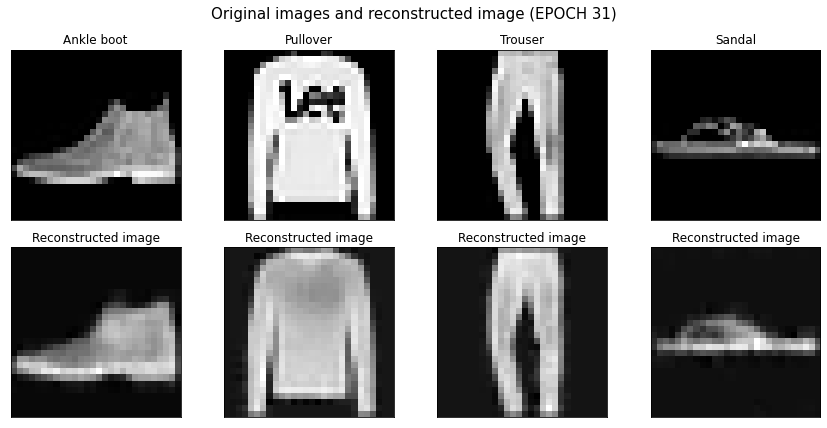

 70%|███████   | 35/50 [39:32<20:32, 82.20s/it]

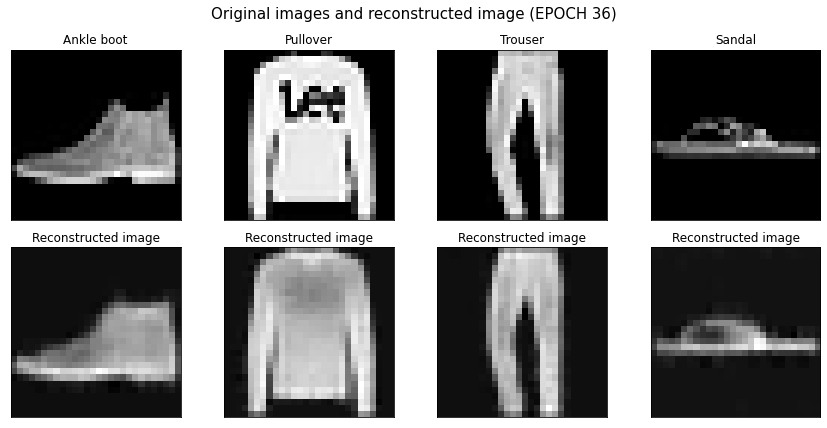

 80%|████████  | 40/50 [46:51<14:31, 87.13s/it]

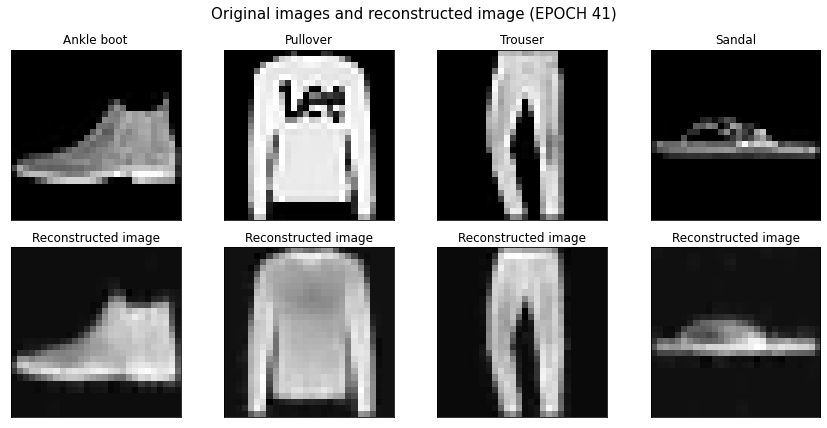

 90%|█████████ | 45/50 [53:47<06:56, 83.22s/it]

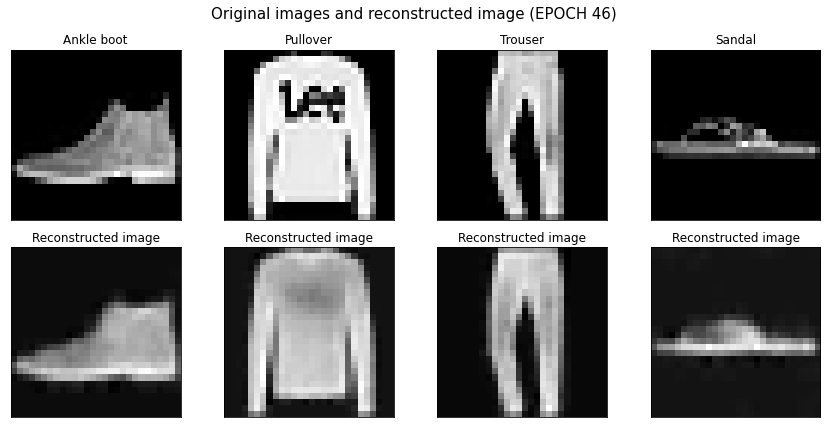

100%|██████████| 50/50 [1:00:19<00:00, 72.39s/it]


In [15]:
train_loss, validation_loss = AE.training_cycle(device,
                                train_dataloader,
                                test_dataloader,
                                loss_fn,
                                optim,
                                n_epochs,
                                test_dataset,
                                encoded_space_dim,
                                plot = True,
                                keep_plots = True,
                                keep_model=True,
                                verbose = False)

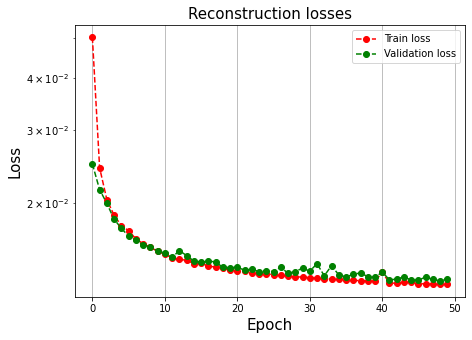

In [16]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(validation_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Reconstruction losses",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Img/best_model_losses.svg', format='svg')
plt.show()

# Latent space exploration

**2 pt - explore the latent space structure (e.g., PCA, t-SNE) and generate new samples from latent codes**

## Retrieve the encoded vector for each image in the test set

In [19]:
AE = my_models.Autoencoder(trial.params["encoded_space_dim"],trial.params["nf"])

In [20]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [21]:
# Load network parameters
AE.encoder.load_state_dict(torch.load('Models/encoder_params.pth'))
AE.decoder.load_state_dict(torch.load('Models/decoder_params.pth'))

<All keys matched successfully>

In [22]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE.encoder.eval()
    with torch.no_grad():
        encoded_img  = AE.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:06<00:00, 1470.77it/s]


In [23]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

Enc. Variable 0  Enc. Variable 1  Enc. Variable 2  Enc. Variable 3  \
0            1.508009       -10.457845        10.246497         7.102372   
1            2.430800         2.762399        32.832294        -9.174961   
2          -13.159552        11.513021        -7.059504        -7.251584   
3           -7.771400         8.752426        -4.916780        -5.547465   
4            1.622871         0.637388        13.867114        -4.839376   
...               ...              ...              ...              ...   
9995         3.026417       -15.978197        16.460352         7.144343   
9996        -7.936514         5.520120        -1.981441        -4.034759   
9997        -7.491274         1.239986         6.247990         1.824168   
9998        -8.704298         7.843448        -6.599033        -5.386504   
9999         0.293096        -3.056922         6.683305         3.431518   

      Enc. Variable 4  Enc. Variable 5  Enc. Variable 6  Enc. Variable 7  \
0            0.959796         3.818996         2.572135         7.850259   
1           -3.147040         7.541510        -3.081761       -13.995875   
2            0.485268        10.087305        -7.852633         3.858110   
3           -5.355045         8.779428        -4.278242         2.671270   
4           -4.033059         7.472864        -7.620906       -16.530001   
...               ...              ...              ...              ...   
9995         8.802240         8.145755        -9.009412         4.572686   
9996        -3.894708         5.534730        -1.758798         1.728830   
9997       -10.461185        -4.676823       -14.242400        -4.480959   
9998        -3.012419        14.426508        -2.157800         6.912650   
9999         1.434283         2.318009         0.892738         2.372342   

      Enc. Variable 8  Enc. Variable 9  label  
0           -6.080394        -1.558422      9  
1            5.174322       -11.839590      2  
2           -0.068516       -10.177427      1  
3            2.093649        -0.610962      1  
4            1.360015        -0.191972      6  
...               ...              ...    ...  
9995        -3.976320        -2.810113      9  
9996         0.078555         1.645432      1  
9997       -10.368550        -1.960982      8  
9998        -3.826991         1.071180      1  
9999        -7.919405         0.391331      5  

[10000 rows x 11 columns]

## PCA

In [24]:
pca = PCA(n_components=2)
encoded_samples_reduced_PCA = pca.fit_transform(encoded_samples)


In [25]:
pca_df = pd.DataFrame(encoded_samples_reduced_PCA)
pca_df['label'] = encoded_samples.label 


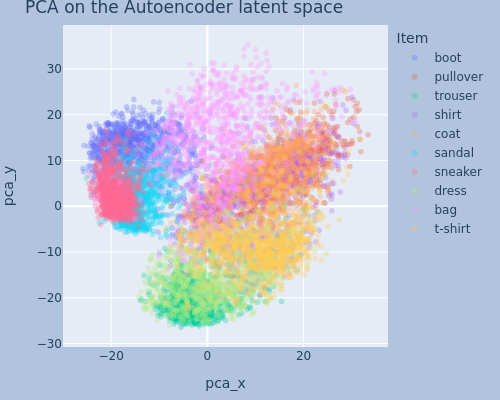

In [26]:
fig = px.scatter(pca_df, x=0, y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="PCA on the Autoencoder latent space",
                labels={"0":"pca_x","1":"pca_y","color":"Item"})

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")
fig.write_image("Img/CAE_PCA.svg")

## TSNE

In [27]:
tsne = TSNE(n_components=2)
encoded_samples_reduced_TSNE = tsne.fit_transform(encoded_samples)


/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [28]:
tsne_df = pd.DataFrame(encoded_samples_reduced_TSNE)
tsne_df['label'] = encoded_samples.label 


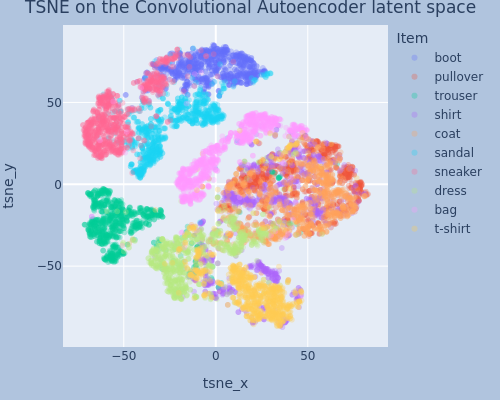

In [29]:
fig = px.scatter(tsne_df, x=0, y=1, color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="TSNE on the Convolutional Autoencoder latent space",
                labels={"0":"tsne_x","1":"tsne_y","color":"Item"})

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")
fig.write_image("Img/CAE_TSNE.svg")

## Sample generation

For the sample generation I will go to a model with a latent space dimension equal to two.

In [30]:
encoded_space_dim = 2
max_epochs     = 20
learning_rate  = 0.0067
regularization = 0.
nf             = 8

In [31]:
# Initialize the autoencoder
AE_2 = my_models.Autoencoder(encoded_space_dim,nf)

In [32]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': AE_2.encoder.parameters()},
    {'params': AE_2.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
AE_2.to(device)

Selected device: cpu


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=288, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
    (4): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (5): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (6): ReLU(inplace=True)
    (7): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (8): ReLU(inplac

In [33]:
_,_ =AE_2.training_cycle(device,
                train_dataloader,
                test_dataloader,
                loss_fn,
                optim,
                max_epochs,
                test_dataset,
                2)

  0%|          | 0/20 [00:00<?, ?it/s]

EPOCH 1/20
AVERAGE TRAIN LOSS: 0.04952109232544899


  5%|▌         | 1/20 [00:15<04:54, 15.52s/it]

AVERAGE TEST LOSS: 0.03693064674735069
EPOCH 2/20
AVERAGE TRAIN LOSS: 0.03542637079954147


 10%|█         | 2/20 [00:30<04:38, 15.45s/it]

AVERAGE TEST LOSS: 0.03526351600885391
EPOCH 3/20
AVERAGE TRAIN LOSS: 0.035181183367967606


 15%|█▌        | 3/20 [00:46<04:22, 15.46s/it]

AVERAGE TEST LOSS: 0.034085310995578766
EPOCH 4/20
AVERAGE TRAIN LOSS: 0.03240285441279411


 20%|██        | 4/20 [01:01<04:07, 15.48s/it]

AVERAGE TEST LOSS: 0.03218982368707657
EPOCH 5/20
AVERAGE TRAIN LOSS: 0.03135830536484718


 25%|██▌       | 5/20 [01:17<03:53, 15.55s/it]

AVERAGE TEST LOSS: 0.031117547303438187
EPOCH 6/20
AVERAGE TRAIN LOSS: 0.030961010605096817


 30%|███       | 6/20 [01:33<03:37, 15.55s/it]

AVERAGE TEST LOSS: 0.030676579102873802
EPOCH 7/20
AVERAGE TRAIN LOSS: 0.030516937375068665


 35%|███▌      | 7/20 [01:48<03:22, 15.61s/it]

AVERAGE TEST LOSS: 0.030954375863075256
EPOCH 8/20
AVERAGE TRAIN LOSS: 0.03044457919895649


 40%|████      | 8/20 [02:04<03:08, 15.67s/it]

AVERAGE TEST LOSS: 0.03019876405596733
EPOCH 9/20
AVERAGE TRAIN LOSS: 0.030292276293039322


 45%|████▌     | 9/20 [02:20<02:52, 15.70s/it]

AVERAGE TEST LOSS: 0.030085429549217224
EPOCH 10/20
AVERAGE TRAIN LOSS: 0.029829885810613632


 50%|█████     | 10/20 [02:36<02:36, 15.68s/it]

AVERAGE TEST LOSS: 0.029811810702085495
EPOCH 11/20
AVERAGE TRAIN LOSS: 0.029626622796058655


 55%|█████▌    | 11/20 [02:51<02:21, 15.68s/it]

AVERAGE TEST LOSS: 0.029665455222129822
EPOCH 12/20
AVERAGE TRAIN LOSS: 0.029609618708491325


 60%|██████    | 12/20 [03:07<02:05, 15.66s/it]

AVERAGE TEST LOSS: 0.030907606706023216
EPOCH 13/20
AVERAGE TRAIN LOSS: 0.029439019039273262


 65%|██████▌   | 13/20 [03:22<01:49, 15.65s/it]

AVERAGE TEST LOSS: 0.029486382380127907
EPOCH 14/20
AVERAGE TRAIN LOSS: 0.0291550625115633


 70%|███████   | 14/20 [03:38<01:33, 15.61s/it]

AVERAGE TEST LOSS: 0.029494857415556908
EPOCH 15/20
AVERAGE TRAIN LOSS: 0.028969792649149895


 75%|███████▌  | 15/20 [03:54<01:17, 15.60s/it]

AVERAGE TEST LOSS: 0.029362525790929794
EPOCH 16/20
AVERAGE TRAIN LOSS: 0.02886619232594967


 80%|████████  | 16/20 [04:09<01:02, 15.62s/it]

AVERAGE TEST LOSS: 0.02887849137187004
EPOCH 17/20
AVERAGE TRAIN LOSS: 0.028849460184574127


 85%|████████▌ | 17/20 [04:25<00:46, 15.59s/it]

AVERAGE TEST LOSS: 0.028955567628145218
EPOCH 18/20
AVERAGE TRAIN LOSS: 0.028873290866613388


 90%|█████████ | 18/20 [04:40<00:31, 15.59s/it]

AVERAGE TEST LOSS: 0.029763177037239075
EPOCH 19/20
AVERAGE TRAIN LOSS: 0.028966307640075684


 95%|█████████▌| 19/20 [04:56<00:15, 15.57s/it]

AVERAGE TEST LOSS: 0.028889155015349388
EPOCH 20/20
AVERAGE TRAIN LOSS: 0.028758952394127846


100%|██████████| 20/20 [05:12<00:00, 15.60s/it]

AVERAGE TEST LOSS: 0.02908198907971382


Lets check the latent space

In [34]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    AE_2.encoder.eval()
    with torch.no_grad():
        encoded_img  = AE_2.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:04<00:00, 2134.29it/s]


In [35]:
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)
print(min(encoded_samples["Enc. Variable 0"]), max(encoded_samples["Enc. Variable 0"]))
print(min(encoded_samples["Enc. Variable 1"]), max(encoded_samples["Enc. Variable 1"]))

-11.876349449157715 6.163282871246338
-3.4096689224243164 18.766387939453125


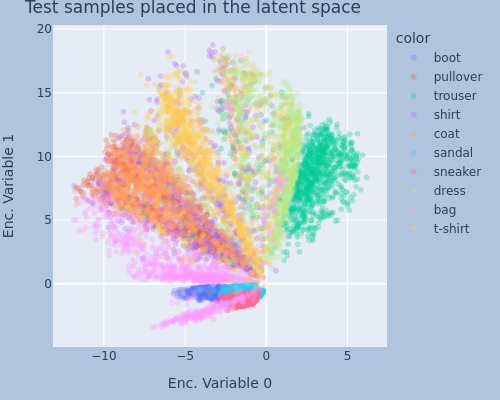

In [36]:
fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="Test samples placed in the latent space")

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")

In [37]:
def image_generator(x,y,decoder,device):
    decoder.to(device)
    #move the input to the GPU and predict the output
    decoder.eval()
    latent_space_vector = torch.tensor([[x,y]])
    latent_space_vector.to(device)
    with torch.no_grad():
        # Encode the data
        decoded_img   = decoder(latent_space_vector)    
    return decoded_img.squeeze().cpu().numpy()

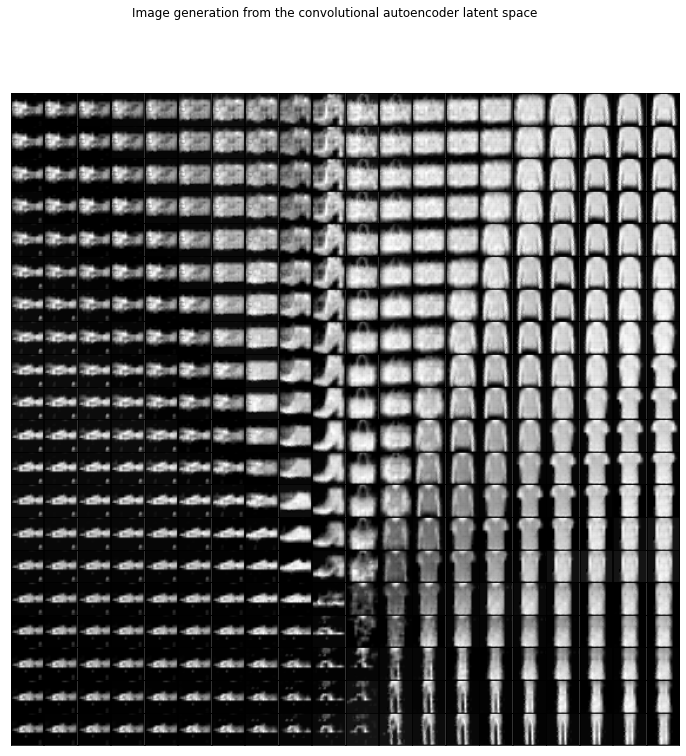

In [38]:
fig, axs = plt.subplots(20, 20, figsize=(12,12))
fig.suptitle("Image generation from the convolutional autoencoder latent space")
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
X = np.linspace(-10, 2, num=20).astype(np.float32)
Y = np.linspace(-10, 10, num=20).astype(np.float32)
i = 0
for x in X:
    for y in Y: 
        img = image_generator(x,y,AE_2.decoder,device)
        axs[i].imshow(img, cmap='gist_gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i +=1
# Save figures
fig.savefig('./Img/CAE_generation.svg', format='svg')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

Autoencoders are not designed to generate data, the lack of this ability is closely related to the lack of regularity (order) in the latent space [Here there is a bit about it and why GANS are capable of doing so](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

# Fine tuning - Transfer learning

**1 pt - fine-tune the (convolutional) autoencoder using a supervised classification task, and compare classification accuracy and learning speed with results achieved in Homework 1**

## Data

In [39]:
#Define a validation dataset
train_percent = 0.7
n_train      = int(train_percent * len(train_dataset))
n_validation = len(train_dataset) - n_train
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [n_train, n_validation])

print('# of training samples  :',len(train_dataset))
print('# of validation samples:',len(val_dataset))
print('# of test samples      :',len(test_dataset))


# of training samples  : 42000
# of validation samples: 18000
# of test samples      : 10000


In [40]:
batch_size = 256
train_dataloader      = DataLoader(train_dataset,  batch_size=batch_size,        shuffle=True, num_workers=0)
validation_dataloader = DataLoader(val_dataset,    batch_size=len(val_dataset),  shuffle=False, num_workers=0)
test_dataloader       = DataLoader(test_dataset,   batch_size=len(test_dataset), shuffle=False, num_workers=0)


## Transfer the autoencoder encoder weights to the supervised network

In [41]:
encoded_space_dim = trial.params["encoded_space_dim"]
nf = trial.params["nf"]

In [42]:
# Initialize the old autoencoder
AE = my_models.Autoencoder(encoded_space_dim,nf)
# Load network parameters
AE.encoder.load_state_dict(torch.load('./Models/encoder_params.pth'))

<All keys matched successfully>

In [43]:
#Initialize the Autoencoder for fine tuning
FTAE = my_models.Fine_Tuned_Autoencoder(encoded_space_dim,AE)


In [44]:
FTAE

Fine_Tuned_Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=576, out_features=64, bias=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=64, out_features=10, bias=True)
  )
  (fine_tuner): Linear(in_features=10, out_features=10, bias=True)
)

In [45]:
### Disable the weight update for the trained encoder
for param_name, param in FTAE.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[7].parameters():
    param.requires_grad = True
    
### Allow weight update (training) of the last layers (linear layers)
for param in FTAE.encoder[9].parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in FTAE.encoder.named_parameters():
    print(param_name,param.requires_grad)

0.weight False
0.bias False
2.weight False
2.bias False
4.weight False
4.bias False
7.weight True
7.bias True
9.weight True
9.bias True


In [46]:
learning_rate       = 1e-3
regularization_term = 0.
n_epochs = 50

In [47]:
### Define the loss function
loss_fn = nn.CrossEntropyLoss()

### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': FTAE.encoder.parameters()},
    {'params': FTAE.fine_tuner.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization_term)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

Selected device: cpu


In [48]:
train, test = FTAE.tune_training_cycle(device,
                                       train_dataloader,
                                       validation_dataloader,
                                       loss_fn,
                                       optim,
                                       n_epochs,
                                       test_dataloader,
                                      verbose=False)

100%|██████████| 50/50 [22:43<00:00, 27.27s/it]


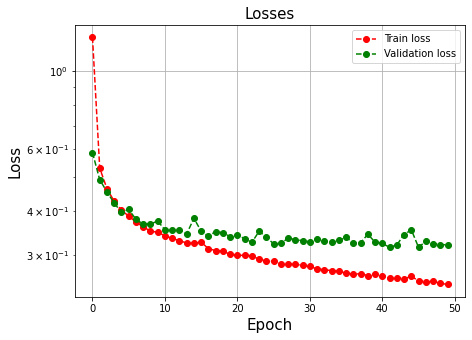

In [49]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
plt.savefig('./Img/fine_tunning_losses.svg', format='svg')
plt.show()

In [50]:
test_acc = 0

FTAE.to(device)

with torch.no_grad():
    for x_batched, y_batched in test_dataloader:
        # Move data to device
        x_batched = x_batched.to(device)
        y_batched = y_batched.to(device)

        # forward the data
        out = FTAE.forward(x_batched,"Test")

        y_test = y_batched.detach().cpu().numpy()
        y_pred = np.argmax(out.detach().cpu().numpy(), axis = 1)

        right = np.sum(y_pred == y_test)
        test_acc = test_acc + right

print(f"The obtained accuracy is {test_acc/len(test_dataset)*100} %")

The obtained accuracy is 87.85 %


In [51]:
def confussion_plot(real, prediction):
    categories = ['T-shirt/top','Trouser','Pullover',
                    'Dress','Coat','Sandal','Shirt',
                    'Sneaker','Bag','Ankle boot']

    array = confusion_matrix(real, prediction,normalize="true")
    df_cm = pd.DataFrame(array, index = categories, columns = categories)
    
    fig = plt.figure(figsize=(8,7))
    sns.heatmap(df_cm, annot=True, fmt='.2f')
    plt.ylabel("Correct",fontsize=15)
    plt.xlabel("Predicted",fontsize=15)
    plt.title("Confussion matrix",fontsize=15)
    plt.savefig('./Img/confussion.svg', format='svg')
    plt.show()

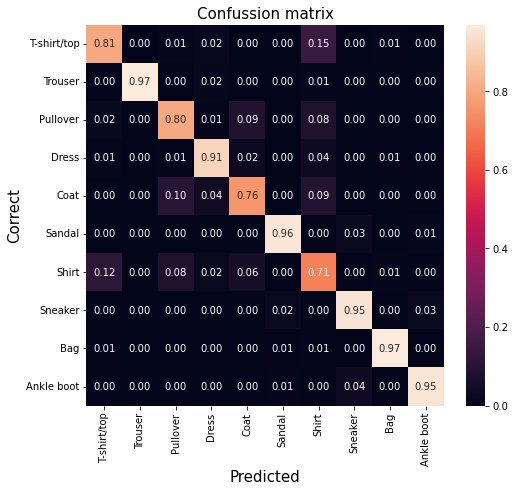

In [52]:
confussion_plot(y_test, y_pred)

In [53]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      1000
           1       0.99      0.97      0.98      1000
           2       0.79      0.80      0.80      1000
           3       0.88      0.91      0.90      1000
           4       0.82      0.76      0.79      1000
           5       0.96      0.96      0.96      1000
           6       0.66      0.71      0.69      1000
           7       0.93      0.95      0.94      1000
           8       0.97      0.97      0.97      1000
           9       0.96      0.95      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Generative models


**2 pt: implement and test variational (convolutional) autoencoder or GAN or SimCLR**

## Variational Autoencoder


![LALA](./Img/variational_autoencoder.png)

[VAES by towarddatascience](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

- a variational autoencoder can be defined as being an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.
-  instead of encoding an input as a single point, we encode it as a distribution over the latent space.
- The model is then trained as follows:

    - first, the input is encoded as distribution over the latent space

    - second, a point from the latent space is sampled from that distribution
    
    - third, the sampled point is decoded and the reconstruction error can be computed
    - finally, the reconstruction error is backpropagated through the network

[GANS by towarddatasicence](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

In [7]:
encoded_space_dim = 2
max_epochs     = 50
learning_rate  = 0.0067
regularization = 0.
nf = 8

In [8]:
# Initialize the autoencoder
VAE = my_models.Variational_Autoencoder(encoded_space_dim, nf)

In [9]:
### Define an optimizer (both for the encoder and the decoder!)
params_to_optimize = [
    {'params': VAE.encoder.parameters()},
    {'params': VAE.decoder.parameters()}
]
optim = torch.optim.Adam(params_to_optimize, lr=learning_rate, weight_decay=regularization)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')


Selected device: cpu


In [10]:
train, test = VAE.training_cycle(device,
                                 train_dataloader,
                                   test_dataloader,
                                   optim,
                                   max_epochs,
                                   test_dataset,
                                   beta = 0.8,
                                   verbose = False)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [28:37<00:00, 34.35s/it]


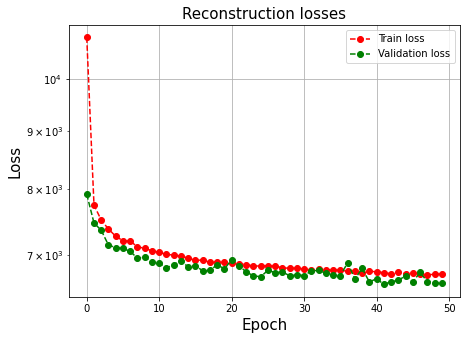

In [11]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Reconstruction losses",fontsize=15)
plt.grid()
plt.legend()
#plt.ylim(0,2)
plt.savefig('./Img/Variational_AE_losses.svg', format='svg')
plt.show()


In [12]:
### Get the encoded representation of the test samples
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    with torch.no_grad():
        _,latent_mn,latent_std = VAE.forward(img, "Test")
        encoded_img = VAE.sampler(latent_mn,latent_std)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
# Convert to a dataframe
encoded_samples = pd.DataFrame(encoded_samples)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:19<00:00, 522.92it/s]


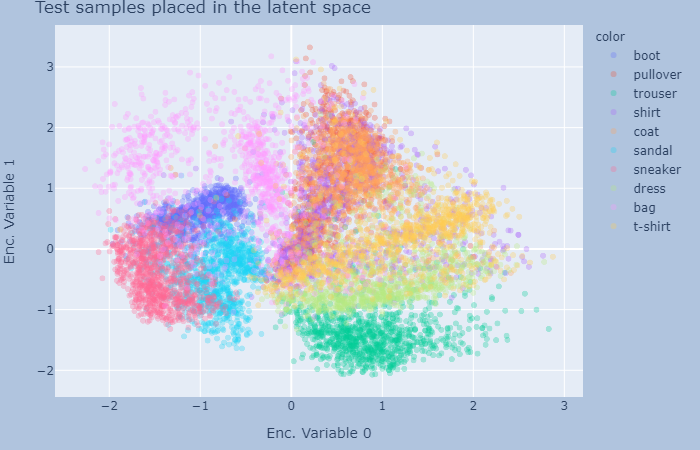

In [13]:
fig = px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=[label_names[l] for l in encoded_samples.label.to_numpy()],
                 opacity=0.3,
                 width=500,
                 height=400,
                 title="Test samples placed in the latent space")

fig.update_layout(
    margin=dict(l=20, r=20, t=25, b=20),
    paper_bgcolor="LightSteelBlue",
)

fig.show("png")
fig.write_image("Img/VAE_latent_space.svg")

In [14]:
def image_generator(x,y,decoder,device):
    decoder.to(device)
    #move the input to the GPU and predict the output
    decoder.eval()
    latent_space_vector = torch.tensor([[x,y]])
    latent_space_vector.to(device)
    with torch.no_grad():
        # Encode the data
        decoded_img   = decoder(latent_space_vector)    
    return decoded_img.squeeze().cpu().numpy()

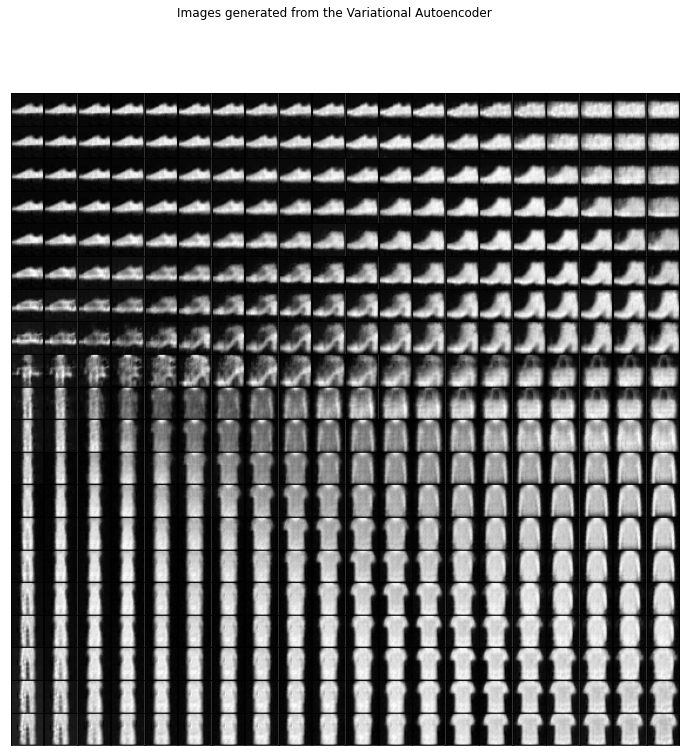

In [15]:
fig, axs = plt.subplots(20, 20, figsize=(12,12))
fig.suptitle("Images generated from the Variational Autoencoder")
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
X = np.linspace(-2, 2, num=20).astype(np.float32)
Y = np.linspace(-1, 1, num=20).astype(np.float32)
i = 0
for x in X:
    for y in Y: 
        img = image_generator(x,y,VAE.decoder,device)
        axs[i].imshow(img, cmap='gist_gray')
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        i +=1
# Save figures
fig.savefig('./Img/VAE_generation.svg', format='svg')
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
plt.close()

## GAN - Generative Adversarial Network

[A bit of theory](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29) and a [bit of coding](https://towardsdatascience.com/building-a-gan-with-pytorch-237b4b07ca9a). But based on [this post](https://realpython.com/generative-adversarial-networks/#the-architecture-of-generative-adversarial-networks).

Goodfellow et al., in their original paper Generative Adversarial Networks, proposed an interesting idea: use a very well-trained classifier to distinguish between a generated image and an actual image. If such a classifier exists, we can create and train a generator network until it can output images that can completely fool the classifier.

![LALA](./Img/GAN_pipeline.jpeg)

In [7]:
batch_size =32

### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


In [8]:
class Discriminator(nn.Module):
    def __init__(self,dp=0.3):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dp),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), 784)
        output = self.model(x)
        return output

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output
    
    
def sample_generator_to_train_discriminator(real_samples, device, batch_size):
    
    # Assign label 1 to real images
    real_samples = real_samples.to(device)
    real_labels  = torch.ones((batch_size,1)).to(device)
    
    # Generate some fake images
    noise_sample = torch.randn((batch_size, 100)).to(device)
    fake_samples = generator(noise_sample)
    fake_labels  = torch.zeros((batch_size, 1)).to(device)
    
    # Concatenate all the data which will serve as training dataset for the discriminator
    all_samples = torch.cat((real_samples,fake_samples))
    all_labels  = torch.cat((real_labels, fake_labels))
    
    return all_samples, all_labels,real_labels

In [9]:
learning_rate = 0.0001
regularization = 0.
num_epochs = 200


In [10]:
discriminator = Discriminator()
generator = Generator()

In [11]:
### Define the loss function
loss_fn = nn.BCELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)
optimizer_generator     = torch.optim.Adam(generator.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
discriminator.to(device)
generator.to(device)

Selected device: cpu


Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [12]:
loss_discriminator_ = []
loss_generator_     = []

for epoch in tqdm(range(num_epochs)):
    for n, (real_samples, mnist_labels) in enumerate(train_dataloader):
        
        
        ### Data for training the discriminator
        all_samples,all_samples_labels,real_samples_labels = sample_generator_to_train_discriminator(real_samples, device, batch_size)

        
        ### Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator   = loss_fn(output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        ### Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100)).to(device=device)  # Sample some noise to feed the generator

        ### Training the generator
        generator.zero_grad()
        generated_samples              = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        
        loss_generator = loss_fn(output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step()

        # Show loss
        if n == batch_size - 1:
            loss_batch_discriminator = loss_discriminator.detach().cpu().numpy()
            loss_batch_generator = loss_generator.detach().cpu().numpy()
            loss_discriminator_.append(loss_batch_discriminator)
            loss_generator_.append(loss_batch_generator)
            #Save model
            if (epoch % 5==0):
                torch.save(generator.state_dict(), f'./Models/GAN_generator_epoch_{epoch}.pth')
                print(f"Epoch: {epoch} Loss D.: {loss_batch_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_batch_generator}")

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 Loss D.: 0.6709100604057312
Epoch: 0 Loss G.: 0.45609837770462036


  2%|▎         | 5/200 [05:59<4:07:34, 76.18s/it]

Epoch: 5 Loss D.: 0.14622862637043
Epoch: 5 Loss G.: 2.238445520401001


  5%|▌         | 10/200 [12:33<4:07:29, 78.16s/it]

Epoch: 10 Loss D.: 0.43500983715057373
Epoch: 10 Loss G.: 1.661077857017517


  8%|▊         | 15/200 [19:04<4:00:49, 78.10s/it]

Epoch: 15 Loss D.: 0.352311909198761
Epoch: 15 Loss G.: 1.2847169637680054


 10%|█         | 20/200 [25:32<3:52:42, 77.57s/it]

Epoch: 20 Loss D.: 0.4224480390548706
Epoch: 20 Loss G.: 1.4554545879364014


 12%|█▎        | 25/200 [31:59<3:46:12, 77.56s/it]

Epoch: 25 Loss D.: 0.3937518000602722
Epoch: 25 Loss G.: 1.6646829843521118


 15%|█▌        | 30/200 [38:28<3:40:29, 77.82s/it]

Epoch: 30 Loss D.: 0.449160099029541
Epoch: 30 Loss G.: 1.7135562896728516


 18%|█▊        | 35/200 [44:55<3:32:35, 77.30s/it]

Epoch: 35 Loss D.: 0.47650855779647827
Epoch: 35 Loss G.: 1.5543876886367798


 20%|██        | 40/200 [51:37<3:35:16, 80.73s/it]

Epoch: 40 Loss D.: 0.4712533950805664
Epoch: 40 Loss G.: 1.2489880323410034


 22%|██▎       | 45/200 [59:14<3:56:19, 91.48s/it]

Epoch: 45 Loss D.: 0.3594386577606201
Epoch: 45 Loss G.: 1.3807440996170044


 25%|██▌       | 50/200 [1:07:39<4:08:29, 99.40s/it]

Epoch: 50 Loss D.: 0.4086496829986572
Epoch: 50 Loss G.: 1.6927438974380493


 28%|██▊       | 55/200 [1:16:11<4:07:00, 102.21s/it]

Epoch: 55 Loss D.: 0.5237741470336914
Epoch: 55 Loss G.: 1.5378954410552979


 30%|███       | 60/200 [1:24:52<4:02:22, 103.88s/it]

Epoch: 60 Loss D.: 0.28930822014808655
Epoch: 60 Loss G.: 1.5802834033966064


 32%|███▎      | 65/200 [1:33:29<3:52:53, 103.51s/it]

Epoch: 65 Loss D.: 0.40319859981536865
Epoch: 65 Loss G.: 1.35652494430542


 35%|███▌      | 70/200 [1:42:05<3:43:39, 103.23s/it]

Epoch: 70 Loss D.: 0.3082927465438843
Epoch: 70 Loss G.: 1.602556586265564


 38%|███▊      | 75/200 [1:50:42<3:35:44, 103.56s/it]

Epoch: 75 Loss D.: 0.37152063846588135
Epoch: 75 Loss G.: 1.4591697454452515


 40%|████      | 80/200 [1:59:22<3:28:00, 104.01s/it]

Epoch: 80 Loss D.: 0.39064502716064453
Epoch: 80 Loss G.: 1.6580694913864136


 42%|████▎     | 85/200 [2:08:03<3:19:35, 104.13s/it]

Epoch: 85 Loss D.: 0.4466361999511719
Epoch: 85 Loss G.: 1.4480023384094238


 45%|████▌     | 90/200 [2:16:45<3:11:02, 104.20s/it]

Epoch: 90 Loss D.: 0.30571335554122925
Epoch: 90 Loss G.: 1.7404687404632568


 48%|████▊     | 95/200 [2:25:25<3:01:55, 103.96s/it]

Epoch: 95 Loss D.: 0.4889337122440338
Epoch: 95 Loss G.: 1.5109823942184448


 50%|█████     | 100/200 [2:34:04<2:53:10, 103.90s/it]

Epoch: 100 Loss D.: 0.38164323568344116
Epoch: 100 Loss G.: 1.7296143770217896


 52%|█████▎    | 105/200 [2:42:41<2:43:58, 103.56s/it]

Epoch: 105 Loss D.: 0.3412086069583893
Epoch: 105 Loss G.: 1.7923256158828735


 55%|█████▌    | 110/200 [2:51:15<2:34:29, 102.99s/it]

Epoch: 110 Loss D.: 0.39703118801116943
Epoch: 110 Loss G.: 1.717958688735962


 57%|█████▊    | 115/200 [2:59:49<2:25:33, 102.75s/it]

Epoch: 115 Loss D.: 0.412795752286911
Epoch: 115 Loss G.: 1.814476728439331


 60%|██████    | 120/200 [3:08:26<2:17:41, 103.27s/it]

Epoch: 120 Loss D.: 0.34479090571403503
Epoch: 120 Loss G.: 1.8181822299957275


 62%|██████▎   | 125/200 [3:17:00<2:08:48, 103.05s/it]

Epoch: 125 Loss D.: 0.3127364218235016
Epoch: 125 Loss G.: 2.0522124767303467


 65%|██████▌   | 130/200 [3:25:34<1:59:51, 102.74s/it]

Epoch: 130 Loss D.: 0.23690064251422882
Epoch: 130 Loss G.: 2.092224359512329


 68%|██████▊   | 135/200 [3:34:09<1:51:38, 103.06s/it]

Epoch: 135 Loss D.: 0.2691100537776947
Epoch: 135 Loss G.: 1.3804265260696411


 70%|███████   | 140/200 [3:42:44<1:42:57, 102.96s/it]

Epoch: 140 Loss D.: 0.3567253053188324
Epoch: 140 Loss G.: 1.9026678800582886


 72%|███████▎  | 145/200 [3:51:19<1:34:24, 102.99s/it]

Epoch: 145 Loss D.: 0.3537784516811371
Epoch: 145 Loss G.: 1.5205107927322388


 75%|███████▌  | 150/200 [3:59:52<1:25:35, 102.70s/it]

Epoch: 150 Loss D.: 0.33357492089271545
Epoch: 150 Loss G.: 2.249680519104004


 78%|███████▊  | 155/200 [4:08:31<1:17:52, 103.84s/it]

Epoch: 155 Loss D.: 0.33981209993362427
Epoch: 155 Loss G.: 1.7119801044464111


 80%|████████  | 160/200 [4:17:10<1:09:10, 103.77s/it]

Epoch: 160 Loss D.: 0.38211482763290405
Epoch: 160 Loss G.: 1.5974246263504028


 82%|████████▎ | 165/200 [4:25:54<1:01:04, 104.70s/it]

Epoch: 165 Loss D.: 0.253944993019104
Epoch: 165 Loss G.: 1.8139934539794922


 85%|████████▌ | 170/200 [4:34:40<52:28, 104.96s/it]  

Epoch: 170 Loss D.: 0.24729228019714355
Epoch: 170 Loss G.: 2.4302213191986084


 88%|████████▊ | 175/200 [4:43:21<43:26, 104.26s/it]

Epoch: 175 Loss D.: 0.5186262130737305
Epoch: 175 Loss G.: 1.8852708339691162


 90%|█████████ | 180/200 [4:52:03<34:46, 104.33s/it]

Epoch: 180 Loss D.: 0.38498610258102417
Epoch: 180 Loss G.: 1.769134759902954


 92%|█████████▎| 185/200 [5:00:42<26:01, 104.07s/it]

Epoch: 185 Loss D.: 0.5254701972007751
Epoch: 185 Loss G.: 1.9922332763671875


 95%|█████████▌| 190/200 [5:09:22<17:18, 103.88s/it]

Epoch: 190 Loss D.: 0.3452998995780945
Epoch: 190 Loss G.: 1.9872822761535645


 98%|█████████▊| 195/200 [5:18:02<08:39, 103.84s/it]

Epoch: 195 Loss D.: 0.31034737825393677
Epoch: 195 Loss G.: 1.9023855924606323


100%|██████████| 200/200 [5:26:43<00:00, 98.02s/it] 


### Losses

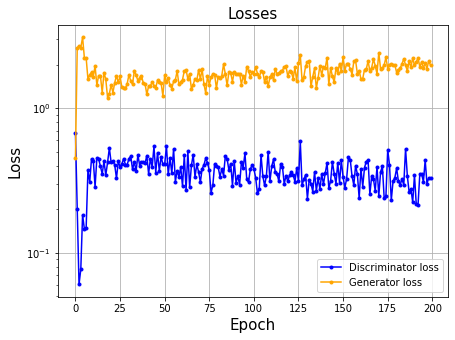

In [13]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(loss_discriminator_, linestyle='-', marker='.', color='b', label='Discriminator loss')
plt.semilogy(loss_generator_, linestyle='-', marker='.', color='orange', label='Generator loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
plt.savefig('./Img/gan_losses.svg', format='svg')
plt.show()

### Image generation

In [14]:
import imageio
from IPython.display import Image

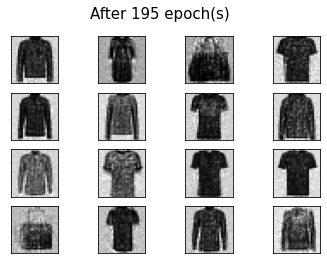

In [15]:
every_n = [i for i in range(num_epochs)]
for j in every_n[::5]:
    # Load network parameters
    generator.load_state_dict(torch.load(f'Models/GAN_generator_epoch_{j}.pth'))

    latent_space_samples = torch.randn(batch_size, 100).to(device)
    generated_samples = generator(latent_space_samples)

    generated_samples = generated_samples.cpu().detach()
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(generated_samples[i].reshape(28, 28), cmap="gray_r")
        plt.xticks([])
        plt.yticks([])
    plt.suptitle(f'After {j} epoch(s)',fontsize=15)    
    plt.savefig(f"./Img/GAN/{j}.png")

In [16]:
# Build GIF
every_n = [i for i in range(200)]
gif_files = [f"./Img/GAN/{j}.png" for j in every_n[::5]]
with imageio.get_writer('./Img/GAN.gif', mode='I') as writer:
    for filename in gif_files:
        image = imageio.imread(filename)
        writer.append_data(image)
    
gif = imageio.mimread('./Img/GAN.gif')
gif_speed_up = './Img/GAN.gif'
imageio.mimsave(gif_speed_up, gif, fps=2)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


In [2]:
#Image(url='./Img/GAN.gif')  
Image(url='./GAN.gif')  